In [460]:
import pandas as pd
import numpy as np
import seaborn as sns
from tabulate import tabulate
import matplotlib.pyplot as plt
import pickle
import requests
import os
from bs4 import BeautifulSoup
import time, random

In [382]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import PorterStemmer
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, GridSearchCV, HalvingRandomSearchCV, HalvingGridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/archana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/archana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/archana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Read in the Data

In [413]:
filename = "data/booksummaries.txt"
lines = open(filename).read().splitlines()
len(lines)

16559

### Process Data in DataFrame

In [414]:
titles = []
authors = []
pubDates = []
genres = []
summaries = []
for line in range(0,len(lines)):
    content = lines[line].split('/m/', 1)[1].split('\t', 1)[1]
    fields = content.split('\t')
    title = fields[0]
    titles.append(title)
    author = fields[1]
    authors.append(author)
    pubDate = fields[2]
    if pubDate == '':
        pubDate = np.nan
    pubDates.append(pubDate)
    genreDict = fields[3]
    genre = ''
    summary = fields[-1]
    try:
        genreDict = eval(genreDict)
        for val in genreDict.values():
            genre += val + ' '
    except:
        genre = np.nan
    
    genres.append(genre)
    summary = summary.replace('\'', '')
    summaries.append(summary)
    

In [415]:
books_df = pd.DataFrame({'Title':titles, 'Author':authors, 'PublishedDate': pubDates,'Genre':genres, 'Summary':summaries})
books_df

,Title,Author,PublishedDate,Genre,Summary
0,Animal Farm,George Orwell,1945-08-17,Roman à clef Satire Children's literature Spec...,"Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,Anthony Burgess,1962,Science Fiction Novella Speculative fiction Ut...,"Alex, a teenager living in near-future Englan..."
2,The Plague,Albert Camus,1947,Existentialism Fiction Absurdist fiction Novel,The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,Vernor Vinge,NaN,Hard science fiction Science Fiction Speculati...,The novel posits that space around the Milky ...
...,...,...,...,...,...
16554,Under Wildwood,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ..."
16555,Transfer of Power,Vince Flynn,2000-06-01,Thriller Fiction,The reader first meets Rapp while he is doing...
16556,Decoded,Jay-Z,2010-11-16,Autobiography,The book follows very rough chronological ord...
16557,America Again: Re-becoming The Greatness We Ne...,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...


In [416]:
books_df['BookId'] = np.nan
with open('data/book_ids.pkl', 'rb') as f:
    book_id_list = pickle.load(f)

len(book_id_list)

12882

In [417]:
for val_tuple in book_id_list:
    if(isinstance(val_tuple, tuple)):
        name = val_tuple[0]
        book_id = val_tuple[1]
        books_df['BookId'] = np.where(name == books_df['Title'],book_id, books_df['BookId'])

In [418]:
books_df = books_df[['Title', 'BookId', 'Author', 'PublishedDate', 'Genre', 'Summary']]
books_df

,Title,BookId,Author,PublishedDate,Genre,Summary
0,Animal Farm,170448,George Orwell,1945-08-17,Roman à clef Satire Children's literature Spec...,"Old Major, the old boar on the Manor Farm, ca..."
1,A Clockwork Orange,41817486,Anthony Burgess,1962,Science Fiction Novella Speculative fiction Ut...,"Alex, a teenager living in near-future Englan..."
2,The Plague,11989,Albert Camus,1947,Existentialism Fiction Absurdist fiction Novel,The text of The Plague is divided into five p...
3,An Enquiry Concerning Human Understanding,130119,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...
4,A Fire Upon the Deep,77711,Vernor Vinge,NaN,Hard science fiction Science Fiction Speculati...,The novel posits that space around the Milky ...
...,...,...,...,...,...,...
16554,Under Wildwood,10353049,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ..."
16555,Transfer of Power,184655,Vince Flynn,2000-06-01,Thriller Fiction,The reader first meets Rapp while he is doing...
16556,Decoded,8425806,Jay-Z,2010-11-16,Autobiography,The book follows very rough chronological ord...
16557,America Again: Re-becoming The Greatness We Ne...,nan,Stephen Colbert,2012-10-02,NaN,Colbert addresses topics including Wall Stree...


In [419]:
books_df['BookId'] = books_df['BookId'].astype(str)

In [420]:
books_df['BookId'] = np.where(books_df['BookId'] == 'nan', np.nan, books_df['BookId'])

In [421]:
books_df['Author'] = books_df['Author'].astype(str)

In [422]:
books_df['Author'] = np.where(books_df['Author'] == '', np.nan, books_df['Author'])

In [423]:
books_df_clean = books_df.dropna(subset=['BookId', 'Author'])

In [424]:
books_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 10366 entries, 0 to 16556
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          10366 non-null  object
 1   BookId         10366 non-null  object
 2   Author         10366 non-null  object
 3   PublishedDate  7637 non-null   object
 4   Genre          8876 non-null   object
 5   Summary        10366 non-null  object
dtypes: object(6)
memory usage: 566.9+ KB


In [470]:
books_df_clean  = books_df_clean.reset_index().drop(columns=['index'])
books_df_clean

,Title,BookId,Author,PublishedDate,Genre,Summary,NewGenre,Fiction
0,Animal Farm,170448,George Orwell,1945-08-17,Roman à clef Satire Children's literature Spec...,"Old Major, the old boar on the Manor Farm, ca...",fantasy,1
1,A Clockwork Orange,41817486,Anthony Burgess,1962,Science Fiction Novella Speculative fiction Ut...,"Alex, a teenager living in near-future Englan...",horror,1
2,The Plague,11989,Albert Camus,1947,Existentialism Fiction Absurdist fiction Novel,The text of The Plague is divided into five p...,philosophy,1
3,An Enquiry Concerning Human Understanding,130119,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...,philosophy,0
4,A Fire Upon the Deep,77711,Vernor Vinge,NaN,Hard science fiction Science Fiction Speculati...,The novel posits that space around the Milky ...,fantasy,1
...,...,...,...,...,...,...,...,...
10361,Telegraph Avenue,10756240,Michael Chabon,NaN,NaN,"Set during the summer of 2004, the novel main...",,1
10362,The Simpsons: A Complete Guide to Our Favorite...,452298,Matt Groening,1997-11-12,NaN,"{| class=""wikitable"" |- !Seasons covered !Boo...",,1
10363,Under Wildwood,10353049,Colin Meloy,2012-09-25,NaN,"Prue McKeel, having rescued her brother from ...",,1
10364,Transfer of Power,184655,Vince Flynn,2000-06-01,Thriller Fiction,The reader first meets Rapp while he is doing...,,1


In [471]:
main_genres = ['humor', 'comedy', 'horror', 'fantasy', 'historical', 'romance', 'thriller', 'mystery','crime', 'science', 'philosophy']
#search for fiction or nonfiction  and children and young adult

In [472]:
books_df_clean.shape[0]

10366

In [475]:
'''books_df_clean['NewGenre'] = ''
books_df_clean['Fiction'] = 1
book_base_url = 'https://www.goodreads.com/book/show/'
genre_set = 0
fiction_set = 0
success = 0
for row in range(0,books_df_clean.shape[0]):
    genre_set=0
    fiction_set = 0
    success = 0
    while(not success):
        id = books_df_clean.loc[row, 'BookId']
        book_url = book_base_url + str(id)
        response = requests.get(book_url) 
        if(response.status_code != 200):
             time.sleep(3)
             success = False
        else:
            doc = BeautifulSoup(response.text, 'html.parser')
            book_tags = doc.find_all('div', class_="BookPageMetadataSection__genres")
            try:
                spans = book_tags[0].find_all('span', class_='Button__labelItem')
                for span in spans:
                    genre = str(span.string).lower()
                    if(not fiction_set):
                        if(genre== 'nonfiction'):
                            books_df_clean.loc[row, 'Fiction'] = 0
                            fiction_set=1
                        elif(genre == 'fiction'):
                            books_df_clean.loc[row, 'Fiction'] = 1
                            fiction_set = 1
                    if(not genre_set):
                        if(any(genre in x  for x in main_genres)):
                            books_df_clean.loc[row, 'NewGenre'] = genre
                            genre_set=1
            except IndexError:
                print("no genre for " + id)
        success = True
        time.sleep(random.randint(1,4))'''
    

no genre for 10574488
no genre for 141537891
no genre for 210435300
no genre for 11561212
no genre for 61173454
no genre for 11561212
no genre for 210434827
no genre for 208190111
no genre for 214052476
no genre for 44291207
no genre for 165378908
no genre for 19179590
no genre for 214860192
no genre for 58127000
no genre for 22594588
no genre for 592839
no genre for 116132
no genre for 150065985
no genre for 124118349
no genre for 136469615
no genre for 7093749
no genre for 35701115
no genre for 58527184
no genre for 65640708
no genre for 171226932
no genre for 165765068
no genre for 42653393
no genre for 134242223
no genre for 161687051
no genre for 75402327
no genre for 133496932
no genre for 135250921
no genre for 28430278
no genre for 198559797
no genre for 127212179
no genre for 167984487
no genre for 124061219
no genre for 7982079
no genre for 11561212
no genre for 37214842
no genre for 143094738
no genre for 7242661
no genre for 207911012
no genre for 207838262
no genre for 608

ConnectionError: ('Connection aborted.', RemoteDisconnected('Remote end closed connection without response'))

In [479]:
books_df_clean.iloc[10339:,:]

,Title,BookId,Author,PublishedDate,Genre,Summary,NewGenre,Fiction
10339,Belenggu,2179306,Armijn Pane,NaN,NaN,"The novel begins as Sukartono (Tono), a Dutch...",romance,1
10340,Wisdom's Daughter,537901,H. Rider Haggard,NaN,Fantasy,"As Holly points out, the story is told from S...",fantasy,1
10341,Der Wehrwolf,2666638,Hermann Löns,NaN,Novel,The Thirty Years War is at its height and the...,,1
10342,Who Killed Zebedee?,1009213,Wilkie Collins,NaN,Detective fiction Short story,"""Who Killed Zebedee?,"" opens with a direct ad...",mystery,1
10343,Der Schimmelreiter,1210271,Theodor Storm,1888,NaN,"The novella tells the story of Hauke Haien, a...",,1
10344,From This Wicked Patch of Dust,11139782,Sergio Troncoso,2011-09,Novel,"In the border shantytown of Ysleta, Texas, Me...",,1
10345,The Democratic Paradox,656218,Chantal Mouffe,2000,NaN,The eponymous paradox of democracy that this ...,philosophy,0
10346,Beautiful Chaos,3382666,Gary Russell,NaN,Fantasy Speculative fiction Young adult litera...,"After returning home, more strange things are...",fantasy,1
10347,Kaytek the Wizard,13218804,Janusz Korczak,NaN,NaN,The book depicts a schoolboy who gains magic ...,fantasy,1
10348,The Family Corleone,12918218,Edward Falco,2012-05-08,Crime Fiction,"The novel, set in the Great Depression, tells...",crime,1


In [480]:
##pickle dataframe for backup
with open('data/books_df_clean.pkl', 'wb') as f:
    pickle.dump(books_df_clean,f)

In [482]:
with open('data/books_df_clean.pkl', 'rb') as f:
    books_df_final = pickle.load(f)

In [485]:
books_df_final['NewGenre'] = np.where(books_df_final['NewGenre']=='', np.nan, books_df_final['NewGenre'])
books_df_final.isna().sum()

Title               0
BookId              0
Author              0
PublishedDate    2729
Genre            1490
Summary             0
NewGenre         3270
Fiction             0
dtype: int64

In [489]:
books_df = books_df_final.dropna(subset=['NewGenre'])
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7096 entries, 0 to 10364
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          7096 non-null   object
 1   BookId         7096 non-null   object
 2   Author         7096 non-null   object
 3   PublishedDate  5400 non-null   object
 4   Genre          6423 non-null   object
 5   Summary        7096 non-null   object
 6   NewGenre       7096 non-null   object
 7   Fiction        7096 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 498.9+ KB


In [490]:
books_df.query('NewGenre == "roman"')

,Title,BookId,Author,PublishedDate,Genre,Summary,NewGenre,Fiction
333,Son Excellence Eugène Rougon,1367070,Émile Zola,1876,Novel,The novel opens in 1857 with Rougons career a...,roman,1
1083,According to Mary Magdalene,856656,Marianne Fredriksson,1997-03,Fiction Novel,The story offers a feminist perspective on th...,roman,1
1319,The 158-Pound Marriage,4660,John Irving,1974-08-12,Novel,The narrator (who never identifies himself by...,roman,1
1383,The Blue Flowers,28370,Raymond Queneau,1965,Novel,"The Duke of Auge dreams that he is Cidrolin, ...",roman,1
1823,Prochain épisode,3334254,Hubert Aquin,NaN,NaN,"The narrator, like Aquin himself, turns his a...",roman,1
1997,Le Dernier jour d'un condamné,1638235,Victor Hugo,1829,NaN,A man who has been condemned to death by the ...,roman,1
2065,Riz noir,6598469,Anna Moï,2004,Historical novel,The novel takes place during the Vietnam War ...,roman,1
2140,Pharsalia,1268768,Lucan,NaN,NaN,Book I: After a brief introduction lamenting ...,roman,0
2192,Fear and Trembling,71453,Amélie Nothomb,1999,Novel,"Amélie, a young Belgian woman who spent the f...",roman,1
2526,The Fourth Hand,4656,John Irving,2001-07-03,Fiction,"While reporting a story from India, Patrick W...",roman,1


### Clean up data

#### Remove null and duplicates

In [491]:
books_df.isna().sum()

Title               0
BookId              0
Author              0
PublishedDate    1696
Genre             673
Summary             0
NewGenre            0
Fiction             0
dtype: int64

In [492]:
books_df[['Title', 'Author']].duplicated().sum()

2

In [493]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7096 entries, 0 to 10364
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          7096 non-null   object
 1   BookId         7096 non-null   object
 2   Author         7096 non-null   object
 3   PublishedDate  5400 non-null   object
 4   Genre          6423 non-null   object
 5   Summary        7096 non-null   object
 6   NewGenre       7096 non-null   object
 7   Fiction        7096 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 498.9+ KB


In [494]:
books_df = books_df.drop_duplicates(subset=['Title', 'Author'])
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7094 entries, 0 to 10364
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          7094 non-null   object
 1   BookId         7094 non-null   object
 2   Author         7094 non-null   object
 3   PublishedDate  5399 non-null   object
 4   Genre          6421 non-null   object
 5   Summary        7094 non-null   object
 6   NewGenre       7094 non-null   object
 7   Fiction        7094 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 498.8+ KB


In [495]:
books_df[['Title', 'Author']].duplicated().sum()

0

In [496]:
books_df.head(10)

,Title,BookId,Author,PublishedDate,Genre,Summary,NewGenre,Fiction
0,Animal Farm,170448,George Orwell,1945-08-17,Roman à clef Satire Children's literature Spec...,"Old Major, the old boar on the Manor Farm, ca...",fantasy,1
1,A Clockwork Orange,41817486,Anthony Burgess,1962,Science Fiction Novella Speculative fiction Ut...,"Alex, a teenager living in near-future Englan...",horror,1
2,The Plague,11989,Albert Camus,1947,Existentialism Fiction Absurdist fiction Novel,The text of The Plague is divided into five p...,philosophy,1
3,An Enquiry Concerning Human Understanding,130119,David Hume,NaN,NaN,The argument of the Enquiry proceeds by a ser...,philosophy,0
4,A Fire Upon the Deep,77711,Vernor Vinge,NaN,Hard science fiction Science Fiction Speculati...,The novel posits that space around the Milky ...,fantasy,1
5,All Quiet on the Western Front,355697,Erich Maria Remarque,1929-01-29,War novel Roman à clef,"The book tells the story of Paul Bäumer, a Ge...",historical,1
6,A Wizard of Earthsea,13642,Ursula K. Le Guin,1968,Children's literature Fantasy Speculative fict...,"Ged is a young boy on Gont, one of the larger...",fantasy,1
8,Children of Dune,44492286,Frank Herbert,1976,Science Fiction Speculative fiction Children's...,Nine years after Emperor Paul Muaddib walked ...,fantasy,1
10,Carmilla,48037,Sheridan Le Fanu,1872,Gothic fiction,The story is presented by Le Fanu as part of ...,horror,1
12,Dracula,17245,Bram Stoker,1897,Science Fiction Speculative fiction Horror Inv...,"The novel is told in epistolary format, as a ...",horror,1


In [497]:
books_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7094 entries, 0 to 10364
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Title          7094 non-null   object
 1   BookId         7094 non-null   object
 2   Author         7094 non-null   object
 3   PublishedDate  5399 non-null   object
 4   Genre          6421 non-null   object
 5   Summary        7094 non-null   object
 6   NewGenre       7094 non-null   object
 7   Fiction        7094 non-null   int64 
dtypes: int64(1), object(7)
memory usage: 498.8+ KB


In [206]:
'''books_df[books_df['Genre'].str.contains('fiction')].shape# both fiction and non-fiction
books_df[books_df['Genre'].str.contains('non-fiction')].shape#only non-fiction
fict_grps = ['novel', 'fantasy', 'story', 'bildungsroman', 'poetry','prose', 'wuxia', 'erotica', 'children', 'young adult', 'comic']
cond = books_df['Genre'].str.contains('|'.join(fict_grps))
books_df['Genre'] = np.where(cond, books_df.Genre + " fiction", books_df['Genre'])'''


In [209]:
'''nonfict_grps = ['biography', 'criticism', 'travel', 'photography','philosophy', 'computer']
cond = books_df['Genre'].str.contains('|'.join(nonfict_grps))
books_df['Genre'] = np.where(cond, books_df.Genre + " non-fiction", books_df['Genre'])'''

In [212]:
'''major_grp = ['fiction', 'non-fiction']
cond = ~books_df['Genre'].str.contains('|'.join(major_grp))
books_df['Genre'] = np.where(cond, np.nan, books_df['Genre'])# neither fiction or non-fiction'''

#### Simplify `Genre` column 

In [253]:
'''books_df_clean = books_df.copy()
books_df_clean['Genre'] = books_df_clean['Genre'].str.lower().str.strip()'''

In [254]:
'''science_list = ['science', 'alien', 'steampunk']
mystery_list = ['mystery', 'detective', 'suspense']
horror_list = ['gothic', 'horror']
comedy_list = ['comic', 'humour','comedy']
#fiction_list = ['western','albino', 'fairy','picture book', 'wuxia','play', 'anthology', 'drama','novel', 'fiction', 'fantasy', 'roman à clef', 'children', 'story', 'prose', 'young adult', 'magic', 'game']
fiction_update_list = ['albino','novel', 'fiction', 'prose']
short_list = ['story', 'anthology']
biography_list = ['autobiograph', 'biograph', 'memoir']
literary_list = ['literary', 'bildungsroman']
ecopol_list = ['economics', 'politics', 'business']
philosophy_list = ['philosophy', 'existentialism', 'postmodernism']
children_list = ['children', 'picture book', 'fairy']
game_list = ['role-playing', 'game']
essay_list = ['essay', 'treatise']
books_df_clean['Audience'] = 'adult'


#Audience capture from Genre
books_df_clean.loc[books_df_clean['Genre'].str.contains('children'), 'Audience'] = 'children'
books_df_clean.loc[books_df_clean['Genre'].str.contains('young'), 'Audience'] = 'young adult'
#Classify fiction/nonfiction
books_df_clean['Fiction'] = 1
books_df_clean.loc[books_df_clean['Genre'].str.contains("nfic"), 'Fiction'] = 0

#Process genres
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(science_list)), 'Genre'] = 'science'
books_df_clean.loc[books_df_clean['Genre'].str.contains('western'), 'Genre'] = 'western'
books_df_clean.loc[books_df_clean['Genre'].str.contains('young'), 'Genre'] = 'young-adult'
books_df_clean.loc[books_df_clean['Genre'].str.contains('thriller'), 'Genre'] = 'thriller'
books_df_clean.loc[books_df_clean['Genre'].str.contains('fantasy'), 'Genre'] = 'fantasy'
books_df_clean.loc[books_df_clean['Genre'].str.contains('satire'), 'Genre'] = 'satire'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(horror_list)), 'Genre'] = 'horror'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(mystery_list)), 'Genre'] = 'mystery'
books_df_clean.loc[books_df_clean['Genre'].str.contains('historical'), 'Genre'] = 'historical'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(biography_list)), 'Genre'] = 'biography'
books_df_clean.loc[books_df_clean['Genre'].str.contains('crime'), 'Genre'] = 'crime'
books_df_clean.loc[books_df_clean['Genre'].str.contains('romance'), 'Genre'] = 'romance'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(comedy_list)), 'Genre'] = 'comedy'
books_df_clean.loc[books_df_clean['Genre'].str.contains('adventure'), 'Genre'] = 'adventure'
books_df_clean.loc[books_df_clean['Genre'].str.contains('roman à clef'), 'Genre'] = 'roman à clef'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(literary_list)), 'Genre'] = 'literary'
books_df_clean.loc[books_df_clean['Genre'].str.contains('epistolary'), 'Genre'] = 'epistolary'
books_df_clean.loc[books_df_clean['Genre'].str.contains('spiritual'), 'Genre'] = 'spiritual'
books_df_clean.loc[books_df_clean['Genre'].str.contains('spy'), 'Genre'] = 'spy'
books_df_clean.loc[books_df_clean['Genre'].str.contains('sociology'), 'Genre'] = 'sociology'
books_df_clean.loc[books_df_clean['Genre'].str.contains('poetry'), 'Genre'] = 'poetry'
books_df_clean.loc[books_df_clean['Genre'].str.contains('dystopia'), 'Genre'] = 'dystopia'
books_df_clean.loc[books_df_clean['Genre'].str.contains('absurdist'), 'Genre'] = 'absurdist'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(philosophy_list)), 'Genre'] = 'philosophy'
books_df_clean.loc[books_df_clean['Genre'].str.contains('erotica'), 'Genre'] = 'erotic'
books_df_clean.loc[books_df_clean['Genre'].str.contains('religion'), 'Genre'] = 'religion'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(ecopol_list)), 'Genre'] = 'economics/politics'
books_df_clean.loc[books_df_clean['Genre'].str.contains('travel'), 'Genre'] = 'travel'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(children_list)), 'Genre'] = 'children literature'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(short_list)), 'Genre'] = 'short story'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(essay_list)), 'Genre'] = 'essay'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(game_list)), 'Genre'] = 'game'
books_df_clean.loc[books_df_clean['Genre'].str.contains('speculative'), 'Genre'] = 'speculative'
books_df_clean.loc[books_df_clean['Genre'].str.contains('|'.join(fiction_update_list)), 'Genre'] = 'generic-fiction'''


In [498]:
books_df['NewGenre'].value_counts()

NewGenre
fantasy       2929
mystery       1153
historical     636
romance        545
thriller       491
humor          458
horror         398
philosophy     228
crime          133
science         78
roman           37
comedy           8
Name: count, dtype: int64

### Simple Logistic Regression with TFID Vectorizer

In [501]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
le = LabelEncoder()
books_df['GenreNum'] = le.fit_transform(books_df['NewGenre'])
books_df['CollectiveSummary'] = books_df['Title'] + " "  + books_df['Author'] + " " + books_df['Summary']

books_df_shuffled = shuffle(books_df, random_state=42)
X = books_df_shuffled[['CollectiveSummary']]
y = books_df_shuffled[['NewGenre']]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

tfidf_vec = TfidfVectorizer(use_idf=True)
X_train_vec = tfidf_vec.fit_transform(X_train.squeeze())
X_test_vec = tfidf_vec.transform(X_test.squeeze())
lgr_tfidf = LogisticRegression(fit_intercept=True, max_iter=800)
lgr_tfidf.fit(X_train_vec, y_train.squeeze())
y_predict_train = lgr_tfidf.predict(X_train_vec)
score = accuracy_score(y_train.squeeze(), y_predict_train)
print(score)
y_predict_test = lgr_tfidf.predict(X_test_vec)
score = accuracy_score(y_test.squeeze(), y_predict_test)
print(score)



0.768796992481203
0.6149943630214205


In [266]:
X_train_vec.shape

(7018, 87255)

In [267]:
X_test_vec.shape

(2340, 87255)

#### Nine major fiction sub-genres are: Science, Mystery/Crime, Romance, Fantasy, Thriller, Horror, Historical, Western, Young Adult

In [272]:
main_genres = ['science', 'mystery', 'crime', 'romance', 'fantasy', 'thriller', 'horror', 'historical', 'western', 'young-adult']
books_df_fiction = books_df_clean.copy()
books_df_fiction = books_df_fiction[books_df_fiction['Genre'].str.contains('|'.join(main_genres)) & books_df_fiction['Fiction']==1]
books_df_fiction['Genre'].value_counts()

Genre
science        2074
fantasy        1302
mystery         708
historical      587
young-adult     574
thriller        353
crime           184
horror          171
romance         132
western          37
Name: count, dtype: int64

In [273]:
books_df_fiction.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6122 entries, 1 to 16555
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Title              6122 non-null   object
 1   Author             6122 non-null   object
 2   PublishedDate      6122 non-null   object
 3   Genre              6122 non-null   object
 4   Summary            6122 non-null   object
 5   Audience           6122 non-null   object
 6   Fiction            6122 non-null   int64 
 7   GenreNum           6122 non-null   int64 
 8   CollectiveSummary  6122 non-null   object
dtypes: int64(2), object(7)
memory usage: 478.3+ KB


In [274]:
le = LabelEncoder()
books_df_fiction['GenreNum'] = le.fit_transform(books_df_fiction['Genre'])
books_df_fiction['CollectiveSummary'] = books_df_fiction['Title'] + " "  + books_df_fiction['Author'] + " " + books_df_fiction['Summary']
books_df_shuffled = shuffle(books_df_fiction, random_state=42)
X = books_df_shuffled[['CollectiveSummary']]
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

tfidf_vec = TfidfVectorizer(use_idf=True)
X_train_vec = tfidf_vec.fit_transform(X_train.squeeze())
X_test_vec = tfidf_vec.transform(X_test.squeeze())
lgr_tfidf = LogisticRegression(fit_intercept=True, max_iter=800)
lgr_tfidf.fit(X_train_vec, y_train.squeeze())
y_predict_train = lgr_tfidf.predict(X_train_vec)
score = accuracy_score(y_train.squeeze(), y_predict_train)
print(score)
y_predict_test = lgr_tfidf.predict(X_test_vec)
score = accuracy_score(y_test.squeeze(), y_predict_test)
print(score)

0.8176867784796341
0.6610058785107773


In [329]:
class_dict = {}
count = 0
for class_name in le.classes_:
  class_dict.update({count:class_name})
  count += 1
class_dict

{0: 'crime',
 1: 'fantasy',
 2: 'historical',
 3: 'horror',
 4: 'mystery',
 5: 'romance',
 6: 'science',
 7: 'thriller',
 8: 'western',
 9: 'young-adult'}

#### Analyse the summary section of data

In [279]:
books_df_fiction['Summary'].iloc[0]

' Alex, a teenager living in near-future England, leads his gang on nightly orgies of opportunistic, random "ultra-violence." Alexs friends ("droogs" in the novels Anglo-Russian slang, Nadsat) are: Dim, a slow-witted bruiser who is the gangs muscle; Georgie, an ambitious second-in-command; and Pete, who mostly plays along as the droogs indulge their taste for ultra-violence. Characterized as a sociopath and a hardened juvenile delinquent, Alex is also intelligent and quick-witted, with sophisticated taste in music, being particularly fond of Beethoven, or "Lovely Ludwig Van." The novel begins with the droogs sitting in their favorite hangout (the Korova Milkbar), drinking milk-drug cocktails, called "milk-plus", to hype themselves for the nights mayhem. They assault a scholar walking home from the public library, rob a store leaving the owner and his wife bloodied and unconscious, stomp a panhandling derelict, then scuffle with a rival gang. Joyriding through the countryside in a stole

In [283]:
stemmer = PorterStemmer()
stemmer.stem(books_df_fiction['Summary'].iloc[0])

' alex, a teenager living in near-future england, leads his gang on nightly orgies of opportunistic, random "ultra-violence." alexs friends ("droogs" in the novels anglo-russian slang, nadsat) are: dim, a slow-witted bruiser who is the gangs muscle; georgie, an ambitious second-in-command; and pete, who mostly plays along as the droogs indulge their taste for ultra-violence. characterized as a sociopath and a hardened juvenile delinquent, alex is also intelligent and quick-witted, with sophisticated taste in music, being particularly fond of beethoven, or "lovely ludwig van." the novel begins with the droogs sitting in their favorite hangout (the korova milkbar), drinking milk-drug cocktails, called "milk-plus", to hype themselves for the nights mayhem. they assault a scholar walking home from the public library, rob a store leaving the owner and his wife bloodied and unconscious, stomp a panhandling derelict, then scuffle with a rival gang. joyriding through the countryside in a stole

In [284]:
def stemmer(text):
    stem = PorterStemmer()
    word_tokens = word_tokenize(text)
    stopwords_punct = set(punctuation)
    stop_words = set(stopwords.words('english'))
    all_stop_words = [stopwords_punct, stop_words]
    filtered_tokens = [w for w in word_tokens if not w.lower() in all_stop_words]
    return ' '.join([stem.stem(w) for w in filtered_tokens])

books_df_fiction['stemmed summary'] = books_df_fiction['Summary'].apply(stemmer)
books_df_fiction

,Title,Author,PublishedDate,Genre,Summary,Audience,Fiction,GenreNum,CollectiveSummary,stemmed summary
1,A Clockwork Orange,Anthony Burgess,1962,science,"Alex, a teenager living in near-future Englan...",adult,1,6,"A Clockwork Orange Anthony Burgess Alex, a te...","alex , a teenag live in near-futur england , l..."
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,fantasy,"Ged is a young boy on Gont, one of the larger...",children,1,1,A Wizard of Earthsea Ursula K. Le Guin Ged is...,"ged is a young boy on gont , one of the larger..."
8,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,science,"Living on Mars, Deckard is acting as a consul...",adult,1,6,Blade Runner 3: Replicant Night K. W. Jeter L...,"live on mar , deckard is act as a consult to a..."
9,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,science,Beginning several months after the events in ...,adult,1,6,Blade Runner 2: The Edge of Human K. W. Jeter ...,begin sever month after the event in blade run...
21,Children of Dune,Frank Herbert,1976,science,Nine years after Emperor Paul Muaddib walked ...,children,1,6,Children of Dune Frank Herbert Nine years aft...,nine year after emperor paul muaddib walk into...
...,...,...,...,...,...,...,...,...,...,...
16545,Dark Angel,V. C. Andrews,1986-11,young-adult,After the events of Heaven (the first book in...,young adult,1,9,Dark Angel V. C. Andrews After the events of ...,after the event of heaven ( the first book in ...
16546,Gates of Paradise,V. C. Andrews,1989-06,young-adult,"A novel about Annie Stonewall, the daughter o...",young adult,1,9,Gates of Paradise V. C. Andrews A novel about...,"a novel about anni stonewal , the daughter of ..."
16549,The Third Lynx,Timothy Zahn,2007,science,The story starts with former government agent...,adult,1,6,The Third Lynx Timothy Zahn The story starts ...,"the stori start with former govern agent , fra..."
16551,Remote Control,Andy McNab,1997,thriller,The series follows the character of Nick Ston...,adult,1,7,Remote Control Andy McNab The series follows ...,"the seri follow the charact of nick stone , an..."


In [285]:
books_df_fiction['stemmed summary'].iloc[0]

"alex , a teenag live in near-futur england , lead hi gang on nightli orgi of opportunist , random `` ultra-viol . '' alex friend ( `` droog '' in the novel anglo-russian slang , nadsat ) are : dim , a slow-wit bruiser who is the gang muscl ; georgi , an ambiti second-in-command ; and pete , who mostli play along as the droog indulg their tast for ultra-viol . character as a sociopath and a harden juvenil delinqu , alex is also intellig and quick-wit , with sophist tast in music , be particularli fond of beethoven , or `` love ludwig van . '' the novel begin with the droog sit in their favorit hangout ( the korova milkbar ) , drink milk-drug cocktail , call `` milk-plu '' , to hype themselv for the night mayhem . they assault a scholar walk home from the public librari , rob a store leav the owner and hi wife bloodi and unconsci , stomp a panhandl derelict , then scuffl with a rival gang . joyrid through the countrysid in a stolen car , they break into an isol cottag and maul the young

In [286]:
def lemmatizer(text):
    lemmat = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    stopwords_punct = set(punctuation)
    stop_words = set(stopwords.words('english'))
    all_stop_words = [stopwords_punct, stop_words]
    filtered_tokens = [w for w in word_tokens if not w.lower() in all_stop_words]
    return ' '.join([lemmat.lemmatize(w) for w in filtered_tokens])

books_df_fiction['lemmatized summary'] = books_df_fiction['Summary'].apply(lemmatizer)
books_df_fiction

,Title,Author,PublishedDate,Genre,Summary,Audience,Fiction,GenreNum,CollectiveSummary,stemmed summary,lemmatized summary
1,A Clockwork Orange,Anthony Burgess,1962,science,"Alex, a teenager living in near-future Englan...",adult,1,6,"A Clockwork Orange Anthony Burgess Alex, a te...","alex , a teenag live in near-futur england , l...","Alex , a teenager living in near-future Englan..."
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,fantasy,"Ged is a young boy on Gont, one of the larger...",children,1,1,A Wizard of Earthsea Ursula K. Le Guin Ged is...,"ged is a young boy on gont , one of the larger...","Ged is a young boy on Gont , one of the larger..."
8,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,science,"Living on Mars, Deckard is acting as a consul...",adult,1,6,Blade Runner 3: Replicant Night K. W. Jeter L...,"live on mar , deckard is act as a consult to a...","Living on Mars , Deckard is acting a a consult..."
9,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,science,Beginning several months after the events in ...,adult,1,6,Blade Runner 2: The Edge of Human K. W. Jeter ...,begin sever month after the event in blade run...,Beginning several month after the event in Bla...
21,Children of Dune,Frank Herbert,1976,science,Nine years after Emperor Paul Muaddib walked ...,children,1,6,Children of Dune Frank Herbert Nine years aft...,nine year after emperor paul muaddib walk into...,Nine year after Emperor Paul Muaddib walked in...
...,...,...,...,...,...,...,...,...,...,...,...
16545,Dark Angel,V. C. Andrews,1986-11,young-adult,After the events of Heaven (the first book in...,young adult,1,9,Dark Angel V. C. Andrews After the events of ...,after the event of heaven ( the first book in ...,After the event of Heaven ( the first book in ...
16546,Gates of Paradise,V. C. Andrews,1989-06,young-adult,"A novel about Annie Stonewall, the daughter o...",young adult,1,9,Gates of Paradise V. C. Andrews A novel about...,"a novel about anni stonewal , the daughter of ...","A novel about Annie Stonewall , the daughter o..."
16549,The Third Lynx,Timothy Zahn,2007,science,The story starts with former government agent...,adult,1,6,The Third Lynx Timothy Zahn The story starts ...,"the stori start with former govern agent , fra...","The story start with former government agent ,..."
16551,Remote Control,Andy McNab,1997,thriller,The series follows the character of Nick Ston...,adult,1,7,Remote Control Andy McNab The series follows ...,"the seri follow the charact of nick stone , an...",The series follows the character of Nick Stone...


In [287]:
books_df_fiction['lemmatized summary'].iloc[0]

"Alex , a teenager living in near-future England , lead his gang on nightly orgy of opportunistic , random `` ultra-violence . '' Alexs friend ( `` droogs '' in the novel Anglo-Russian slang , Nadsat ) are : Dim , a slow-witted bruiser who is the gang muscle ; Georgie , an ambitious second-in-command ; and Pete , who mostly play along a the droogs indulge their taste for ultra-violence . Characterized a a sociopath and a hardened juvenile delinquent , Alex is also intelligent and quick-witted , with sophisticated taste in music , being particularly fond of Beethoven , or `` Lovely Ludwig Van . '' The novel begin with the droogs sitting in their favorite hangout ( the Korova Milkbar ) , drinking milk-drug cocktail , called `` milk-plus '' , to hype themselves for the night mayhem . They assault a scholar walking home from the public library , rob a store leaving the owner and his wife bloodied and unconscious , stomp a panhandling derelict , then scuffle with a rival gang . Joyriding th

In [290]:
def get_named_entities(text):
    word_tokens = word_tokenize(text)
    pos_tokens = nltk.pos_tag(word_tokens)
    tree = nltk.ne_chunk(pos_tokens)
    named_entities = []
    for word in tree:
        if hasattr(word, 'label'):
            named_entities.append((' '.join(c[0] for c in word.leaves()), word.label()))
    return named_entities
books_df_fiction['named entities'] = books_df_fiction['Summary'].apply(get_named_entities)
books_df_fiction

,Title,Author,PublishedDate,Genre,Summary,Audience,Fiction,GenreNum,CollectiveSummary,stemmed summary,lemmatized summary,named entities
1,A Clockwork Orange,Anthony Burgess,1962,science,"Alex, a teenager living in near-future Englan...",adult,1,6,"A Clockwork Orange Anthony Burgess Alex, a te...","alex , a teenag live in near-futur england , l...","Alex , a teenager living in near-future Englan...","[(Alex, PERSON), (England, GPE), (Alexs, PERSO..."
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,fantasy,"Ged is a young boy on Gont, one of the larger...",children,1,1,A Wizard of Earthsea Ursula K. Le Guin Ged is...,"ged is a young boy on gont , one of the larger...","Ged is a young boy on Gont , one of the larger...","[(Ged, GPE), (Gont, GPE), (Earthsea, GPE), (Ka..."
8,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,science,"Living on Mars, Deckard is acting as a consul...",adult,1,6,Blade Runner 3: Replicant Night K. W. Jeter L...,"live on mar , deckard is act as a consult to a...","Living on Mars , Deckard is acting a a consult...","[(Mars, PERSON), (Deckard, PERSON), (Blade Run..."
9,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,science,Beginning several months after the events in ...,adult,1,6,Blade Runner 2: The Edge of Human K. W. Jeter ...,begin sever month after the event in blade run...,Beginning several month after the event in Bla...,"[(Blade Runner, GPE), (Deckard, PERSON), (Rach..."
21,Children of Dune,Frank Herbert,1976,science,Nine years after Emperor Paul Muaddib walked ...,children,1,6,Children of Dune Frank Herbert Nine years aft...,nine year after emperor paul muaddib walk into...,Nine year after Emperor Paul Muaddib walked in...,"[(Emperor Paul Muaddib, PERSON), (Dune, GPE), ..."
...,...,...,...,...,...,...,...,...,...,...,...,...
16545,Dark Angel,V. C. Andrews,1986-11,young-adult,After the events of Heaven (the first book in...,young adult,1,9,Dark Angel V. C. Andrews After the events of ...,after the event of heaven ( the first book in ...,After the event of Heaven ( the first book in ...,"[(Heaven, GPE), (Casteel Series, ORGANIZATION)..."
16546,Gates of Paradise,V. C. Andrews,1989-06,young-adult,"A novel about Annie Stonewall, the daughter o...",young adult,1,9,Gates of Paradise V. C. Andrews A novel about...,"a novel about anni stonewal , the daughter of ...","A novel about Annie Stonewall , the daughter o...","[(Annie Stonewall, PERSON), (Heaven Casteel Ta..."
16549,The Third Lynx,Timothy Zahn,2007,science,The story starts with former government agent...,adult,1,6,The Third Lynx Timothy Zahn The story starts ...,"the stori start with former govern agent , fra...","The story start with former government agent ,...","[(Frank Compton, PERSON), (Compton, ORGANIZATI..."
16551,Remote Control,Andy McNab,1997,thriller,The series follows the character of Nick Ston...,adult,1,7,Remote Control Andy McNab The series follows ...,"the seri follow the charact of nick stone , an...",The series follows the character of Nick Stone...,"[(Nick Stone, PERSON), (SAS, ORGANIZATION), (B..."


In [291]:
books_df_fiction['named entities'].iloc[0]

[('Alex', 'PERSON'),
 ('England', 'GPE'),
 ('Alexs', 'PERSON'),
 ('Nadsat', 'GPE'),
 ('Georgie', 'GPE'),
 ('Pete', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Beethoven', 'GPE'),
 ('Ludwig Van', 'PERSON'),
 ('Korova Milkbar', 'ORGANIZATION'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Dim', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Deltoid', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Georgie', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Dims', 'PERSON'),
 ('Georgie', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Georgies', 'GPE'),
 ('Alexs', 'PERSON'),
 ('Dim', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alexs Bible', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alexs', 'PERSON'),
 ('Ludovico Technique', 'ORGANIZATION'),
 ('Alex', 'PERSON'),
 ('Fifth', 'PERSON'),
 ('Alex', 'PERSON'),
 ('VIPs', 'ORGANIZATION'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alex', 'PERSON'),
 ('Alexs', 'PERSON'),
 ('Dim', 'PERSON'),
 ('Billyboy', 'PERSON'),
 ('A

In [292]:
def get_pos_tokens(text):
    word_tokens = word_tokenize(text)
    pos_tokens = nltk.pos_tag(word_tokens)
    return pos_tokens
books_df_fiction['pos tokens'] = books_df_fiction['Summary'].apply(get_pos_tokens)
books_df_fiction

,Title,Author,PublishedDate,Genre,Summary,Audience,Fiction,GenreNum,CollectiveSummary,stemmed summary,lemmatized summary,named entities,pos tokens
1,A Clockwork Orange,Anthony Burgess,1962,science,"Alex, a teenager living in near-future Englan...",adult,1,6,"A Clockwork Orange Anthony Burgess Alex, a te...","alex , a teenag live in near-futur england , l...","Alex , a teenager living in near-future Englan...","[(Alex, PERSON), (England, GPE), (Alexs, PERSO...","[(Alex, NNP), (,, ,), (a, DT), (teenager, NN),..."
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,fantasy,"Ged is a young boy on Gont, one of the larger...",children,1,1,A Wizard of Earthsea Ursula K. Le Guin Ged is...,"ged is a young boy on gont , one of the larger...","Ged is a young boy on Gont , one of the larger...","[(Ged, GPE), (Gont, GPE), (Earthsea, GPE), (Ka...","[(Ged, NNP), (is, VBZ), (a, DT), (young, JJ), ..."
8,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,science,"Living on Mars, Deckard is acting as a consul...",adult,1,6,Blade Runner 3: Replicant Night K. W. Jeter L...,"live on mar , deckard is act as a consult to a...","Living on Mars , Deckard is acting a a consult...","[(Mars, PERSON), (Deckard, PERSON), (Blade Run...","[(Living, VBG), (on, IN), (Mars, NNP), (,, ,),..."
9,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,science,Beginning several months after the events in ...,adult,1,6,Blade Runner 2: The Edge of Human K. W. Jeter ...,begin sever month after the event in blade run...,Beginning several month after the event in Bla...,"[(Blade Runner, GPE), (Deckard, PERSON), (Rach...","[(Beginning, VBG), (several, JJ), (months, NNS..."
21,Children of Dune,Frank Herbert,1976,science,Nine years after Emperor Paul Muaddib walked ...,children,1,6,Children of Dune Frank Herbert Nine years aft...,nine year after emperor paul muaddib walk into...,Nine year after Emperor Paul Muaddib walked in...,"[(Emperor Paul Muaddib, PERSON), (Dune, GPE), ...","[(Nine, CD), (years, NNS), (after, IN), (Emper..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16545,Dark Angel,V. C. Andrews,1986-11,young-adult,After the events of Heaven (the first book in...,young adult,1,9,Dark Angel V. C. Andrews After the events of ...,after the event of heaven ( the first book in ...,After the event of Heaven ( the first book in ...,"[(Heaven, GPE), (Casteel Series, ORGANIZATION)...","[(After, IN), (the, DT), (events, NNS), (of, I..."
16546,Gates of Paradise,V. C. Andrews,1989-06,young-adult,"A novel about Annie Stonewall, the daughter o...",young adult,1,9,Gates of Paradise V. C. Andrews A novel about...,"a novel about anni stonewal , the daughter of ...","A novel about Annie Stonewall , the daughter o...","[(Annie Stonewall, PERSON), (Heaven Casteel Ta...","[(A, DT), (novel, NN), (about, IN), (Annie, NN..."
16549,The Third Lynx,Timothy Zahn,2007,science,The story starts with former government agent...,adult,1,6,The Third Lynx Timothy Zahn The story starts ...,"the stori start with former govern agent , fra...","The story start with former government agent ,...","[(Frank Compton, PERSON), (Compton, ORGANIZATI...","[(The, DT), (story, NN), (starts, VBZ), (with,..."
16551,Remote Control,Andy McNab,1997,thriller,The series follows the character of Nick Ston...,adult,1,7,Remote Control Andy McNab The series follows ...,"the seri follow the charact of nick stone , an...",The series follows the character of Nick Stone...,"[(Nick Stone, PERSON), (SAS, ORGANIZATION), (B...","[(The, DT), (series, NN), (follows, VBZ), (the..."


In [297]:
books_df_fiction['pos tokens'].iloc[0]

[('Alex', 'NNP'),
 (',', ','),
 ('a', 'DT'),
 ('teenager', 'NN'),
 ('living', 'NN'),
 ('in', 'IN'),
 ('near-future', 'JJ'),
 ('England', 'NNP'),
 (',', ','),
 ('leads', 'VBZ'),
 ('his', 'PRP$'),
 ('gang', 'NN'),
 ('on', 'IN'),
 ('nightly', 'JJ'),
 ('orgies', 'NNS'),
 ('of', 'IN'),
 ('opportunistic', 'JJ'),
 (',', ','),
 ('random', 'JJ'),
 ('``', '``'),
 ('ultra-violence', 'NN'),
 ('.', '.'),
 ("''", "''"),
 ('Alexs', 'NNP'),
 ('friends', 'NNS'),
 ('(', '('),
 ('``', '``'),
 ('droogs', 'NNS'),
 ("''", "''"),
 ('in', 'IN'),
 ('the', 'DT'),
 ('novels', 'NNS'),
 ('Anglo-Russian', 'JJ'),
 ('slang', 'NN'),
 (',', ','),
 ('Nadsat', 'NNP'),
 (')', ')'),
 ('are', 'VBP'),
 (':', ':'),
 ('Dim', 'NNP'),
 (',', ','),
 ('a', 'DT'),
 ('slow-witted', 'JJ'),
 ('bruiser', 'NN'),
 ('who', 'WP'),
 ('is', 'VBZ'),
 ('the', 'DT'),
 ('gangs', 'NNS'),
 ('muscle', 'NN'),
 (';', ':'),
 ('Georgie', 'NNP'),
 (',', ','),
 ('an', 'DT'),
 ('ambitious', 'JJ'),
 ('second-in-command', 'NN'),
 (';', ':'),
 ('and', 'CC'),

In [296]:
def get_verbs(pos_tokens):
    verb_list = []
    for tuple in pos_tokens:
        if(tuple[1] == 'VB'):
            verb_list.append(tuple[0])
    return verb_list

books_df_fiction['verbs'] = books_df_fiction['pos tokens'].apply(get_verbs)
books_df_fiction

,Title,Author,PublishedDate,Genre,Summary,Audience,Fiction,GenreNum,CollectiveSummary,stemmed summary,lemmatized summary,named entities,pos tokens,verbs
1,A Clockwork Orange,Anthony Burgess,1962,science,"Alex, a teenager living in near-future Englan...",adult,1,6,"A Clockwork Orange Anthony Burgess Alex, a te...","alex , a teenag live in near-futur england , l...","Alex , a teenager living in near-future Englan...","[(Alex, PERSON), (England, GPE), (Alexs, PERSO...","[(Alex, NNP), (,, ,), (a, DT), (teenager, NN),...","[hype, rob, stomp, maul, rapes, burgle, underg..."
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,fantasy,"Ged is a young boy on Gont, one of the larger...",children,1,1,A Wizard of Earthsea Ursula K. Le Guin Ged is...,"ged is a young boy on gont , one of the larger...","Ged is a young boy on Gont , one of the larger...","[(Ged, GPE), (Gont, GPE), (Earthsea, GPE), (Ka...","[(Ged, NNP), (is, VBZ), (a, DT), (young, JJ), ...","[save, be, become, impress, go, love, summon, ..."
8,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,science,"Living on Mars, Deckard is acting as a consul...",adult,1,6,Blade Runner 3: Replicant Night K. W. Jeter L...,"live on mar , deckard is act as a consult to a...","Living on Mars , Deckard is acting a a consult...","[(Mars, PERSON), (Deckard, PERSON), (Blade Run...","[(Living, VBG), (on, IN), (Mars, NNP), (,, ,),...",[kill]
9,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,science,Beginning several months after the events in ...,adult,1,6,Blade Runner 2: The Edge of Human K. W. Jeter ...,begin sever month after the event in blade run...,Beginning several month after the event in Bla...,"[(Blade Runner, GPE), (Deckard, PERSON), (Rach...","[(Beginning, VBG), (several, JJ), (months, NNS...","[hunt, help, hunt, re-visit, believe, Sarah, d..."
21,Children of Dune,Frank Herbert,1976,science,Nine years after Emperor Paul Muaddib walked ...,children,1,6,Children of Dune Frank Herbert Nine years aft...,nine year after emperor paul muaddib walk into...,Nine year after Emperor Paul Muaddib walked in...,"[(Emperor Paul Muaddib, PERSON), (Dune, GPE), ...","[(Nine, CD), (years, NNS), (after, IN), (Emper...","[move, experience, control, kill, be, return, ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16545,Dark Angel,V. C. Andrews,1986-11,young-adult,After the events of Heaven (the first book in...,young adult,1,9,Dark Angel V. C. Andrews After the events of ...,after the event of heaven ( the first book in ...,After the event of Heaven ( the first book in ...,"[(Heaven, GPE), (Casteel Series, ORGANIZATION)...","[(After, IN), (the, DT), (events, NNS), (of, I...","[make, find, talk, go, stop, try, see, continu..."
16546,Gates of Paradise,V. C. Andrews,1989-06,young-adult,"A novel about Annie Stonewall, the daughter o...",young adult,1,9,Gates of Paradise V. C. Andrews A novel about...,"a novel about anni stonewal , the daughter of ...","A novel about Annie Stonewall , the daughter o...","[(Annie Stonewall, PERSON), (Heaven Casteel Ta...","[(A, DT), (novel, NN), (about, IN), (Annie, NN...","[assist, keep]"
16549,The Third Lynx,Timothy Zahn,2007,science,The story starts with former government agent...,adult,1,6,The Third Lynx Timothy Zahn The story starts ...,"the stori start with former govern agent , fra...","The story start with former government agent ,...","[(Frank Compton, PERSON), (Compton, ORGANIZATI...","[(The, DT), (story, NN), (starts, VBZ), (with,...","[be, bypass, help]"
16551,Remote Control,Andy McNab,1997,thriller,The series follows the character of Nick Ston...,adult,1,7,Remote Control Andy McNab The series follows ...,"the seri follow the charact of nick stone , an...",The series follows the character of Nick Stone...,"[(Nick Stone, PERSON), (SAS, ORGANIZATION), (B...","[(The, DT), (series, NN), (follows, VBZ), (the...",[work]


In [298]:
books_df_fiction['verbs'].iloc[0]

['hype',
 'rob',
 'stomp',
 'maul',
 'rapes',
 'burgle',
 'undergo',
 'feel',
 'suffer',
 'listen',
 'learn',
 'commit',
 'keen',
 'be',
 'recognize',
 'continue',
 'use',
 'prevent',
 'realize',
 'extract',
 'attempt',
 'counter',
 'side',
 'outgrow',
 'seek']

In [299]:
books_df_fiction[books_df_fiction['Genre'].str.contains('thriller')]['verbs'].iloc[0]

['defect',
 'defect',
 'ensure',
 'interfere',
 'defect',
 'sink',
 'deliver',
 'detect',
 'contact',
 'prevent',
 'convince',
 'scuttle',
 'prevent',
 'appear',
 'succeed',
 'realizes',
 'ignite',
 'destroy',
 'persuade',
 'surrender',
 'die',
 'shoot',
 'arm',
 'proceed',
 'pursue',
 'engage',
 'fire',
 'begin']

In [300]:
books_df_fiction[books_df_fiction['Genre'].str.contains('thriller')]['verbs'].iloc[1]

['aid',
 'tasks',
 'meet',
 'brief',
 'kidnap',
 'secure',
 'arrange',
 'take',
 'prevent',
 'go',
 'be',
 'hold',
 'send',
 'retrieve',
 'return',
 'accept',
 'be',
 'protect',
 'be',
 'keep']

In [302]:
def get_verb_string(verbs):
    return " ".join(verbs)
books_df_fiction['verb string'] = books_df_fiction['verbs'].apply(get_verb_string)
books_df_fiction

,Title,Author,PublishedDate,Genre,Summary,Audience,Fiction,GenreNum,CollectiveSummary,stemmed summary,lemmatized summary,named entities,pos tokens,verbs,verb string
1,A Clockwork Orange,Anthony Burgess,1962,science,"Alex, a teenager living in near-future Englan...",adult,1,6,"A Clockwork Orange Anthony Burgess Alex, a te...","alex , a teenag live in near-futur england , l...","Alex , a teenager living in near-future Englan...","[(Alex, PERSON), (England, GPE), (Alexs, PERSO...","[(Alex, NNP), (,, ,), (a, DT), (teenager, NN),...","[hype, rob, stomp, maul, rapes, burgle, underg...",hype rob stomp maul rapes burgle undergo feel ...
6,A Wizard of Earthsea,Ursula K. Le Guin,1968,fantasy,"Ged is a young boy on Gont, one of the larger...",children,1,1,A Wizard of Earthsea Ursula K. Le Guin Ged is...,"ged is a young boy on gont , one of the larger...","Ged is a young boy on Gont , one of the larger...","[(Ged, GPE), (Gont, GPE), (Earthsea, GPE), (Ka...","[(Ged, NNP), (is, VBZ), (a, DT), (young, JJ), ...","[save, be, become, impress, go, love, summon, ...",save be become impress go love summon escape p...
8,Blade Runner 3: Replicant Night,K. W. Jeter,1996-10-01,science,"Living on Mars, Deckard is acting as a consul...",adult,1,6,Blade Runner 3: Replicant Night K. W. Jeter L...,"live on mar , deckard is act as a consult to a...","Living on Mars , Deckard is acting a a consult...","[(Mars, PERSON), (Deckard, PERSON), (Blade Run...","[(Living, VBG), (on, IN), (Mars, NNP), (,, ,),...",[kill],kill
9,Blade Runner 2: The Edge of Human,K. W. Jeter,1995-10-01,science,Beginning several months after the events in ...,adult,1,6,Blade Runner 2: The Edge of Human K. W. Jeter ...,begin sever month after the event in blade run...,Beginning several month after the event in Bla...,"[(Blade Runner, GPE), (Deckard, PERSON), (Rach...","[(Beginning, VBG), (several, JJ), (months, NNS...","[hunt, help, hunt, re-visit, believe, Sarah, d...",hunt help hunt re-visit believe Sarah discredi...
21,Children of Dune,Frank Herbert,1976,science,Nine years after Emperor Paul Muaddib walked ...,children,1,6,Children of Dune Frank Herbert Nine years aft...,nine year after emperor paul muaddib walk into...,Nine year after Emperor Paul Muaddib walked in...,"[(Emperor Paul Muaddib, PERSON), (Dune, GPE), ...","[(Nine, CD), (years, NNS), (after, IN), (Emper...","[move, experience, control, kill, be, return, ...",move experience control kill be return recogni...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16545,Dark Angel,V. C. Andrews,1986-11,young-adult,After the events of Heaven (the first book in...,young adult,1,9,Dark Angel V. C. Andrews After the events of ...,after the event of heaven ( the first book in ...,After the event of Heaven ( the first book in ...,"[(Heaven, GPE), (Casteel Series, ORGANIZATION)...","[(After, IN), (the, DT), (events, NNS), (of, I...","[make, find, talk, go, stop, try, see, continu...",make find talk go stop try see continue write ...
16546,Gates of Paradise,V. C. Andrews,1989-06,young-adult,"A novel about Annie Stonewall, the daughter o...",young adult,1,9,Gates of Paradise V. C. Andrews A novel about...,"a novel about anni stonewal , the daughter of ...","A novel about Annie Stonewall , the daughter o...","[(Annie Stonewall, PERSON), (Heaven Casteel Ta...","[(A, DT), (novel, NN), (about, IN), (Annie, NN...","[assist, keep]",assist keep
16549,The Third Lynx,Timothy Zahn,2007,science,The story starts with former government agent...,adult,1,6,The Third Lynx Timothy Zahn The story starts ...,"the stori start with former govern agent , fra...","The story start with former government agent ,...","[(Frank Compton, PERSON), (Compton, ORGANIZATI...","[(The, DT), (story, NN), (starts, VBZ), (with,...","[be, bypass, help]",be bypass help
16551,Remote Control,Andy McNab,1997,thriller,The series follows the character of Nick Ston...,adult,1,7,Remote Control Andy McNab The series follows ...,"the seri follow the charact of nick stone , a

In [307]:
books_df_shuffled = shuffle(books_df_fiction, random_state=42)
X = books_df_shuffled['CollectiveSummary']
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

bayes_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('bayes', MultinomialNB())])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None], 'bayes__alpha':[1,3,5]}
bayes_tfidf_grid = GridSearchCV(estimator= bayes_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
bayes_tfidf_grid.fit(X_train, y_train)
y_predict_train = bayes_tfidf_grid.best_estimator_.predict(X_train)
score = accuracy_score(y_train, y_predict_train)
print(score)
y_predict_test = bayes_tfidf_grid.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_predict_test)
print(score)

0.6747985188412111
0.6094056172436316


In [310]:
books_df_shuffled = shuffle(books_df_fiction, random_state=42)
X = books_df_shuffled['CollectiveSummary']
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

lgr_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('lgr', LogisticRegression(max_iter=5000))])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None], 'lgr__C':[1,2,4,5,10,100]}
lgr_tfidf_grid = GridSearchCV(estimator= lgr_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
lgr_tfidf_grid.fit(X_train, y_train)
y_predict_train = lgr_tfidf_grid.best_estimator_.predict(X_train)
score = accuracy_score(y_train, y_predict_train)
print(score)
y_predict_test = lgr_tfidf_grid.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_predict_test)
print(score)

0.8529732084513177
0.6374918354016982


In [322]:
books_df_fiction[['GenreNum', 'Genre']]

,GenreNum,Genre
1,6,science
6,1,fantasy
8,6,science
9,6,science
21,6,science
...,...,...
16545,9,young-adult
16546,9,young-adult
16549,6,science
16551,7,thriller


In [345]:
predict_probs = lgr_tfidf_grid.best_estimator_.predict_proba(X_test)
predictions = lgr_tfidf_grid.best_estimator_.predict(X_test)
probs_list = []
for prob in predict_probs:
    probs_list.append('/'.join(str(x) for x in prob))

results = pd.DataFrame({'BookName': X_test, 'actual': y_test, 'preds': predictions, 'probs': probs_list})
print(results[results['actual'] != results['preds']].iloc[0,3])
print(results[results['actual'] != results['preds']].iloc[0,1])
print(results[results['actual'] != results['preds']].iloc[0,2])

0.009963910007875342/0.05358642363363319/0.11873915536302734/0.0399882978065252/0.24986510330803444/0.10970913214202642/0.027096079302947374/0.03769860860555947/0.006360340617654856/0.3469929492127163
5
9


In [346]:
class_dict

{0: 'crime',
 1: 'fantasy',
 2: 'historical',
 3: 'horror',
 4: 'mystery',
 5: 'romance',
 6: 'science',
 7: 'thriller',
 8: 'western',
 9: 'young-adult'}

In [350]:
results[results['actual'] == 6][results['actual'] != results['preds']]

/tmp/ipykernel_366312/2662406524.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  results[results['actual'] == 6][results['actual'] != results['preds']]


,BookName,actual,preds,probs
1033,Relic Douglas Preston In and around a fiction...,6,4,0.07643707020369483/0.12705140860595296/0.0795...
7659,"Next Michael Crichton ""This novel is fiction,...",6,2,0.0975062157718072/0.11365772251147037/0.18595...
1519,Eldest Christopher Paolini Eldest begins as A...,6,1,0.0004497163929537112/0.9520614641008899/0.004...
7081,Runaway Tom Clancy Tracking down a runaway fr...,6,9,0.030745761460390018/0.10767194555896883/0.020...
2707,Isle of the Dead Roger Zelazny Sandow is jolt...,6,1,0.005421784129523726/0.5686626822679219/0.0080...
...,...,...,...,...
2622,Callahan's Lady Spider Robinson The storyline...,6,4,0.020528893006912588/0.3391944273420407/0.0449...
828,The Farthest Shore Ursula K. Le Guin A strang...,6,1,0.0008475312708891422/0.9504842063781267/0.001...
9743,Leviathan Scott Westerfeld It is the cusp of ...,6,7,0.0069360670377381865/0.22448357378777056/0.12...
11569,Life As We Knew It Susan Beth Pfeffer Sixteen...,6,9,0.012900034661391651/0.03380652396211041/0.042...


In [353]:
from sklearn.metrics import classification_report
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.45      0.11      0.18        46
           1       0.63      0.67      0.65       326
           2       0.57      0.62      0.59       147
           3       0.25      0.02      0.04        43
           4       0.59      0.71      0.64       177
           5       0.57      0.12      0.20        33
           6       0.70      0.83      0.76       519
           7       0.64      0.34      0.44        88
           8       0.00      0.00      0.00         9
           9       0.58      0.50      0.53       143

    accuracy                           0.64      1531
   macro avg       0.50      0.39      0.40      1531
weighted avg       0.62      0.64      0.61      1531



In [311]:
books_df_shuffled = shuffle(books_df_fiction, random_state=42)
X = books_df_shuffled['CollectiveSummary']
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

dtree_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('dtree', DecisionTreeClassifier())])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None]}
dtree_tfidf_grid = GridSearchCV(estimator= dtree_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
dtree_tfidf_grid.fit(X_train, y_train)
y_predict_train = dtree_tfidf_grid.best_estimator_.predict(X_train)
score = accuracy_score(y_train, y_predict_train)
print(score)
y_predict_test = dtree_tfidf_grid.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_predict_test)
print(score)

1.0
0.4317439581972567


In [313]:
books_df_shuffled = shuffle(books_df_fiction, random_state=42)
X = books_df_shuffled['CollectiveSummary']
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

svc_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('dtree', SVC())])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None]}
svc_tfidf_grid = GridSearchCV(estimator= svc_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
svc_tfidf_grid.fit(X_train, y_train)
y_predict_train = svc_tfidf_grid.best_estimator_.predict(X_train)
score = accuracy_score(y_train, y_predict_train)
print(score)
y_predict_test = svc_tfidf_grid.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_predict_test)
print(score)

0.9464169026355914
0.6420640104506858


In [355]:
predictions= svc_tfidf_grid.best_estimator_.predict(X_test)
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.80      0.09      0.16        46
           1       0.63      0.75      0.69       326
           2       0.61      0.56      0.59       147
           3       0.00      0.00      0.00        43
           4       0.64      0.72      0.68       177
           5       0.00      0.00      0.00        33
           6       0.65      0.84      0.73       519
           7       0.90      0.22      0.35        88
           8       0.00      0.00      0.00         9
           9       0.62      0.46      0.53       143

    accuracy                           0.64      1531
   macro avg       0.49      0.36      0.37      1531
weighted avg       0.62      0.64      0.60      1531



/home/archana/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archana/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/archana/anaconda3/envs/nlp/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [316]:
y_train.value_counts()

GenreNum
6    1555
1     976
4     531
2     440
9     431
7     265
0     138
3     128
5      99
8      28
Name: count, dtype: int64

In [317]:
y_test.value_counts()

GenreNum
6    519
1    326
4    177
2    147
9    143
7     88
0     46
3     43
5     33
8      9
Name: count, dtype: int64

In [358]:
gList = [6,1,4,2,9]
books_df_fiction_ltd = books_df_fiction.query('GenreNum in @gList')
books_df_fiction_ltd['GenreNum'].value_counts()

GenreNum
6    2074
1    1302
4     708
2     587
9     574
Name: count, dtype: int64

In [359]:
books_df_shuffled = shuffle(books_df_fiction_ltd, random_state=42)
X = books_df_shuffled['CollectiveSummary']
y = books_df_shuffled['GenreNum']
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25, random_state=42, stratify=y,shuffle=True)

lgr_ltd_tfidf_pipe = Pipeline([('tfidf', TfidfVectorizer()),
                             ('lgr', LogisticRegression(max_iter=5000))])
params = {'tfidf__max_features': [100,500,1000,2000], 'tfidf__stop_words':['english', None], 'lgr__C':[1,2,4,5,10,100]}
lgr_ltd_tfidf_grid = GridSearchCV(estimator= lgr_ltd_tfidf_pipe, cv=5, scoring='accuracy', param_grid=params)
lgr_ltd_tfidf_grid.fit(X_train, y_train)
y_predict_train = lgr_ltd_tfidf_grid.best_estimator_.predict(X_train)
score = accuracy_score(y_train, y_predict_train)
print(score)
y_predict_test = lgr_ltd_tfidf_grid.best_estimator_.predict(X_test)
score = accuracy_score(y_test, y_predict_test)
print(score)

0.9082125603864735
0.7301829268292683


In [360]:
!pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 4.6 MB/s eta 0:00:000:00:010:00:0101


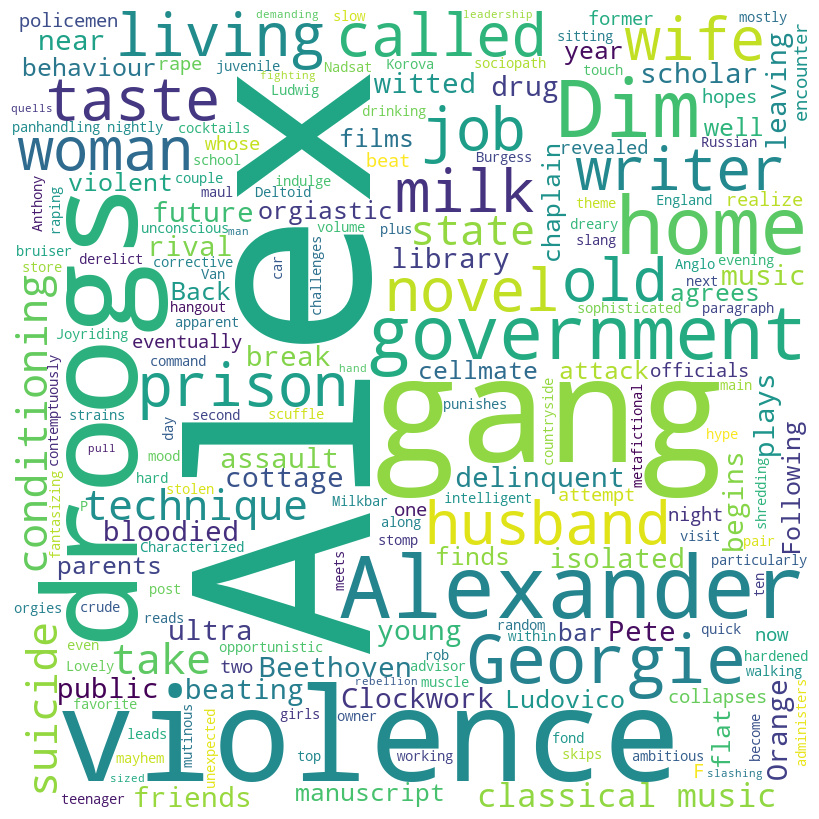

In [367]:
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_fiction_ltd['CollectiveSummary'].iloc[0])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

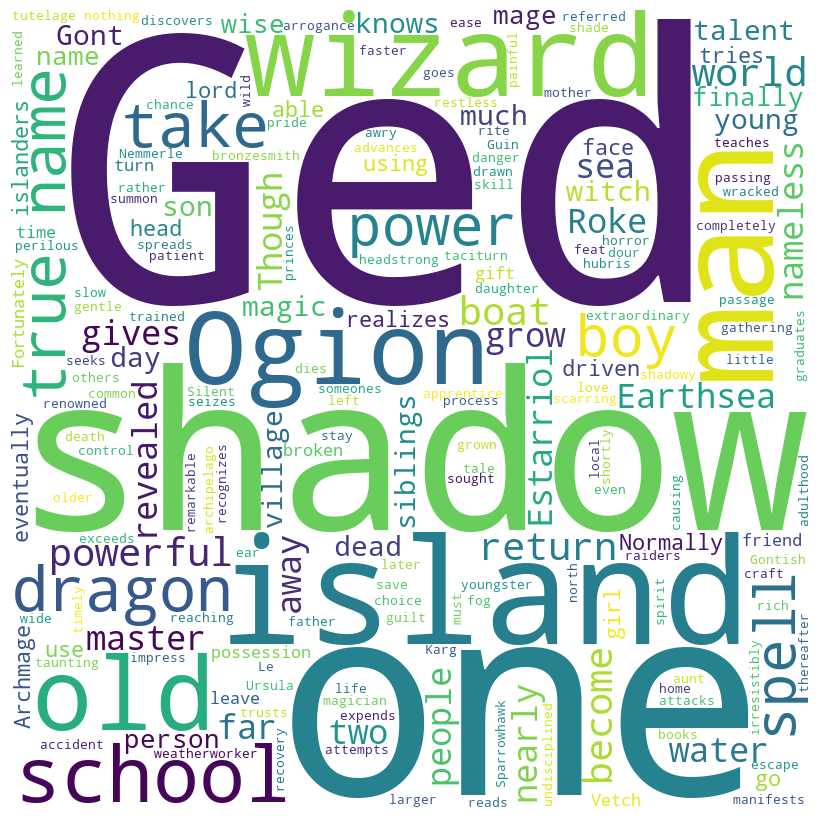

In [368]:
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwords,
                min_font_size = 10).generate(books_df_fiction_ltd['CollectiveSummary'].iloc[1])
 
# plot the WordCloud image                       
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()